In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import BatchNormalization
from keras.layers import Input, Lambda, Dense, Flatten, Activation, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras import applications

2024-03-04 05:53:59.117729: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-04 05:53:59.117846: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-04 05:53:59.221360: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
train = list(os.walk('/kaggle/input/animals/animals/train')) 

In [3]:
label_names = train[0][1]
dict_labels = dict(zip(label_names, list(range(len(label_names)))))
print(dict_labels)

{'horse': 0, 'lion': 1, 'dog': 2, 'elephant': 3, 'cat': 4}


In [4]:
def dataset(path):
    images = []
    labels = []
    for folder in tqdm(os.listdir(path)):
    
        value_of_label = dict_labels[folder] 

        for file in (os.listdir(os.path.join(path, folder))):
            path_of_file = os.path.join(os.path.join(path, folder), file)

            image = cv2.imread(path_of_file)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (150, 150))
            images.append(image)
            labels.append(value_of_label)

    images = np.array(images, dtype = 'float32')/255.0
    labels = np.array(labels)

    return images, labels

images, labels = dataset('/kaggle/input/animals/animals/train')
images, labels = shuffle(images, labels)

100%|██████████| 5/5 [02:24<00:00, 28.94s/it]


In [5]:
images.shape

(13474, 150, 150, 3)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


<Axes: >

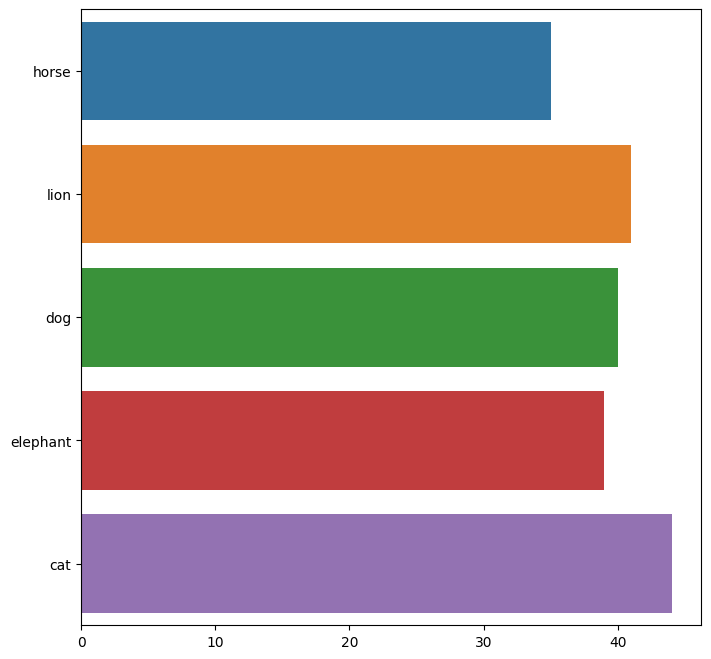

In [6]:
animals = train[0][1]
no_of_animals = []
for _ in range(0, 5):
    no_of_animals.append(len(train[_][0]))
plt.figure(figsize = (8, 8))
sns.barplot(y = animals, x = no_of_animals)

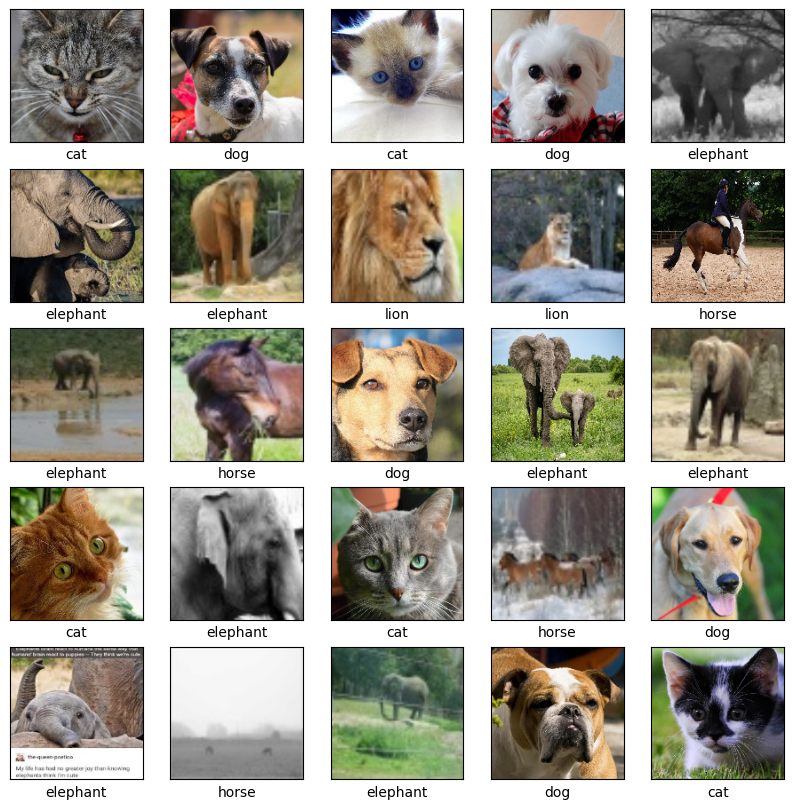

In [7]:
plt.figure(figsize = (10,10))
for _ in range(25):
    plt.subplot(5, 5, _+1)
    plt.yticks([])
    plt.xticks([])
    plt.grid(False)
    data = images[_]
    plt.xlabel(label_names[labels[_]])
    plt.imshow(data);

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator as Generator

In [9]:
train_datagen = Generator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',

)
train_generator = train_datagen.flow_from_directory(
    '/kaggle/input/animals/animals/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    color_mode = 'rgb',
    shuffle = True,
)

validation_datagen = Generator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    '/kaggle/input/animals/animals/val',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    color_mode = 'rgb',
    shuffle = True,
)

Found 13474 images belonging to 5 classes.
Found 1497 images belonging to 5 classes.


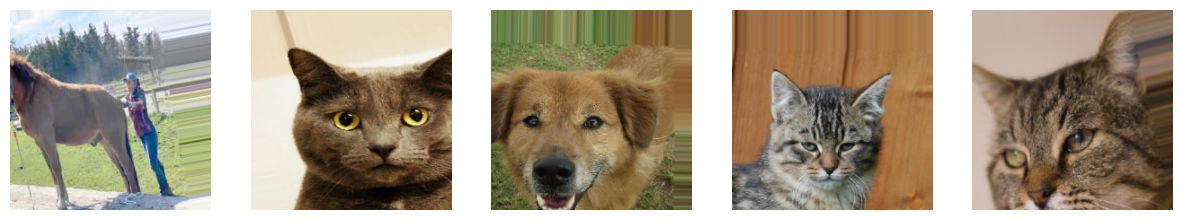

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15,15))

for i in range(5):
    image = next(train_generator)[0][0]
    image = np.squeeze(image)
    ax[i].imshow(image)
    ax[i].axis(False)

In [11]:
from keras.applications.vgg16 import VGG16
from keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,BatchNormalization,Dropout,GlobalAveragePooling2D
from tensorflow.keras.models import Model

In [12]:
model = VGG16(weights=None, include_top=False, input_shape=(224, 224, 3))

x = model.output
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.1)(x)
x = Dense(120, activation='relu')(x)
x = Dropout(0.1)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.1)(x)
predictions = Dense(5, activation='softmax')(x)

model = Model(inputs=model.input, outputs=predictions)

model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 120)            │        30,840 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 14,880,893 (56.77 MB)

 Trainable params: 166,205 (649.24 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [13]:
from tensorflow.keras.metrics import Precision, Recall, F1Score

precision = Precision(name='precision')
recall = Recall(name='recall')
f1_score = F1Score(name='f1_score')

In [14]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', precision, recall, f1_score])

In [15]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping =  EarlyStopping(
        monitor='val_loss',
        min_delta=1e-8,
        patience=10,
        restore_best_weights=True,
        verbose=1)

In [16]:
history = model.fit(train_generator,epochs=50,validation_data=validation_generator,
                   callbacks=[early_stopping])

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-03-04 05:57:06.444813: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.63498, expected 3.85968
2024-03-04 05:57:06.444868: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 6.55784, expected 5.78254
2024-03-04 05:57:06.444883: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 6.61282, expected 5.83752
2024-03-04 05:57:06.444897: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 6.34499, expected 5.56968
2024-03-04 05:57:06.444915: E external/local_xla/xla/service/gpu/buffer_comparator.cc:11

  2/422 ━━━━━━━━━━━━━━━━━━━━ 37s 90ms/step - accuracy: 0.1562 - f1_score: 0.1328 - loss: 1.6500 - precision: 0.0000e+00 - recall: 0.0000e+00   

I0000 00:00:1709531844.384865     139 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


287/422 ━━━━━━━━━━━━━━━━━━━━ 53s 393ms/step - accuracy: 0.5177 - f1_score: 0.5112 - loss: 1.0795 - precision: 0.7248 - recall: 0.2844

2024-03-04 05:59:19.172579: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50176: 3.16198, expected 2.28025
2024-03-04 05:59:19.172648: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50177: 5.67025, expected 4.78852
2024-03-04 05:59:19.172663: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50178: 5.75999, expected 4.87826
2024-03-04 05:59:19.172676: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50179: 4.79602, expected 3.91429
2024-03-04 05:59:19.172690: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50180: 4.89416, expected 4.01243
2024-03-04 05:59:19.172700: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50181: 5.76968, expected 4.88796
2024-03-04 05:59:19.172711: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50182: 4.87763, expected 3.9959
2024-03-04 05:59:19.172722: 

422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - accuracy: 0.5584 - f1_score: 0.5535 - loss: 1.5140 - precision: 0.7417 - recall: 0.3509

2024-03-04 06:00:23.789895: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.73026, expected 4.13229
2024-03-04 06:00:23.789951: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 4.80661, expected 4.20864
2024-03-04 06:00:23.789966: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8: 4.63226, expected 4.03429
2024-03-04 06:00:23.789980: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 10: 4.7562, expected 4.15823
2024-03-04 06:00:23.789997: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 11: 4.11634, expected 3.51837
2024-03-04 06:00:23.790008: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 12: 3.12891, expected 2.53093
2024-03-04 06:00:23.790019: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 13: 4.18796, expected 3.58999
2024-03-04 06:00:23.790030: E external/local_xla/xla

422/422 ━━━━━━━━━━━━━━━━━━━━ 218s 452ms/step - accuracy: 0.5587 - f1_score: 0.5537 - loss: 1.5155 - precision: 0.7418 - recall: 0.3513 - val_accuracy: 0.8464 - val_f1_score: 0.8440 - val_loss: 0.4416 - val_precision: 0.8932 - val_recall: 0.7762
Epoch 2/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 167s 389ms/step - accuracy: 0.7556 - f1_score: 0.7550 - loss: 13.2270 - precision: 0.8157 - recall: 0.6766 - val_accuracy: 0.8504 - val_f1_score: 0.8520 - val_loss: 0.3867 - val_precision: 0.8731 - val_recall: 0.8183
Epoch 3/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 166s 387ms/step - accuracy: 0.7836 - f1_score: 0.7831 - loss: 13.7074 - precision: 0.8275 - recall: 0.7303 - val_accuracy: 0.8691 - val_f1_score: 0.8705 - val_loss: 0.3518 - val_precision: 0.8965 - val_recall: 0.8450
Epoch 4/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 170s 397ms/step - accuracy: 0.8069 - f1_score: 0.8056 - loss: 1.7782 - precision: 0.8474 - recall: 0.7651 - val_accuracy: 0.8383 - val_f1_score: 0.8360 - val_loss: 0.3851 - val_precision: 0.8743 - val_

In [17]:
evaluation = model.evaluate(validation_generator)

47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - accuracy: 0.8683 - f1_score: 0.8681 - loss: 0.3323 - precision: 0.8806 - recall: 0.8537


In [18]:
print("Accuracy:", evaluation[1])
print("Precision:", evaluation[2])
print("Recall:", evaluation[3])
print("F1 Score:", evaluation[4])

Accuracy: 0.8784235119819641
Precision: tf.Tensor([0.99165267 0.98827463 0.77287066 0.8435852  0.79999995], shape=(5,), dtype=float32)
Recall: 0.8921907544136047
F1 Score: 0.862391471862793


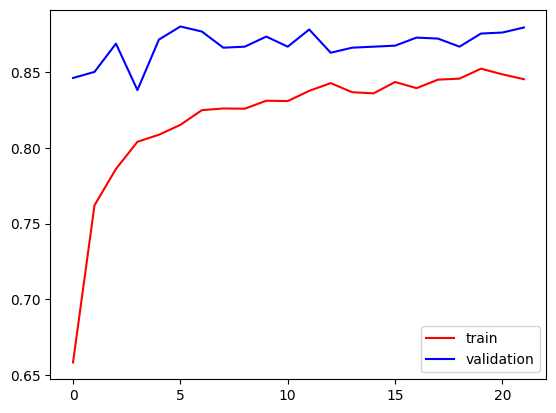

In [19]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

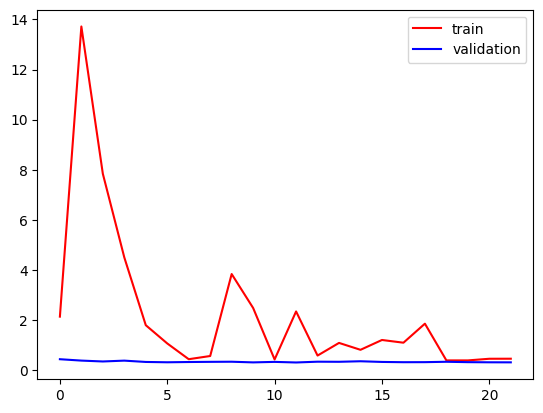

In [20]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

In [21]:
model.save("animal_classifier_vgg16.h5")

In [22]:
train_generator.class_indices

{'cat': 0, 'dog': 1, 'elephant': 2, 'horse': 3, 'lion': 4}

In [23]:
def predictor(img, model):
    image = cv2.imread(img)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    image = np.array(image, dtype = 'float32')/255.0
    plt.imshow(image)
    image = image.reshape(1, 224,224,3)
    
    label_names = train_generator.class_indices
    dict_class = dict(zip(list(range(len(label_names))), label_names))
    clas = model.predict(image).argmax()
    name = dict_class[clas]
    print('The given image is of \nClass: {0} \nAnimal: {1}'.format(clas, name))

2024-03-04 07:01:41.512513: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.42855, expected 3.64542
2024-03-04 07:01:41.512568: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 5.87036, expected 5.08723
2024-03-04 07:01:41.512578: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 6.04003, expected 5.2569
2024-03-04 07:01:41.512586: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 6.22034, expected 5.43722
2024-03-04 07:01:41.512594: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 4.90026, expected 4.11714
2024-03-04 07:01:41.512603: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 5.21068, expected 4.42756
2024-03-04 07:01:41.512610: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 5.92061, expected 5.13748
2024-03-04 07:01:41.512618: E external/local_xla/xla/ser

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
The given image is of 
Class: 1 
Animal: dog


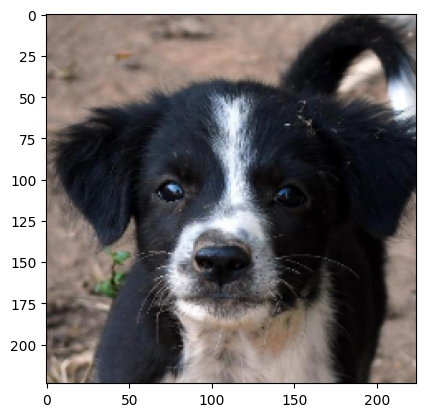

In [24]:
predictor('/kaggle/input/animals/animals/val/dog/dog110.jpg',model)